In [2]:
%pylab inline
%matplotlib auto

from PIL import Image
from urllib.request import urlopen
from io import BytesIO
import numpy as np

import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt

import cv2

import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Using matplotlib backend: <object object at 0x7f06383eb060>


In [2]:
# Defining the kernel to be used in Top-Hat
filterSize =(10, 10)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                   filterSize)
  
# Reading the image named 'input.jpg'
input_image = cv2.imread("2.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
  
# Applying the Black-Hat operation
tophat_img = cv2.morphologyEx(input_image, 
                              cv2.MORPH_BLACKHAT,
                              kernel)
  
cv2.imshow("original", input_image)
cv2.imshow("tophat", tophat_img)
cv2.waitKey(10000)
cv2.destroyAllWindows()

In [5]:
print(tophat_img)

[[0 1 2 ... 0 1 1]
 [1 1 1 ... 0 1 1]
 [3 0 0 ... 0 1 1]
 ...
 [0 0 1 ... 1 1 0]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 1 1 0]]


In [37]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec
    print("="*20)
    df = pd.DataFrame(pts)
    df.columns = ["a", "b"]
    df["l"] = [str(x) for x in labels]

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return [segmented, df]

In [35]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [14]:
img=cv2.imread('2.jpg')

kernel1 = np.ones((2,4),np.uint8)
kernel2 = np.ones((3,3),np.uint8)

imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#imgBW=cv2.threshold(imgGray, 160, 255, cv2.THRESH_BINARY_INV)[1]
imgBW=cv2.adaptiveThreshold(imgGray, 255,
	cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)

img1=cv2.erode(imgBW, kernel1, iterations=1)
img2=cv2.dilate(img1, kernel2, iterations=1)

""" imgf = ResizeWithAspectRatio(imgBW, width=1280)
cv2.imshow("tophat", imgf)
cv2.waitKey(5000)
cv2.destroyAllWindows() """

img3 = cv2.bitwise_and(imgBW,img2)
img3= cv2.bitwise_not(img3)
img4 = cv2.bitwise_and(imgBW,imgBW,mask=img3)

""" imgf = ResizeWithAspectRatio(img4, width=1280)
cv2.imshow("tophat", imgf)
cv2.waitKey(7000)
cv2.destroyAllWindows() """

for j in [1500]:
    imgLines= cv2.HoughLinesP(img4,j,np.pi/2,2, minLineLength = 250, maxLineGap = 70)

    for i in range(len(imgLines)):
        for x1,y1,x2,y2 in imgLines[i]:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

    imgf = ResizeWithAspectRatio(img4, width=1280)
    cv2.imshow("tophat", imgf)
    cv2.waitKey(5000)
    cv2.destroyAllWindows()
cv2.imwrite('2_rec_bw.png',img4)
#cv2.imshow('Final Image with dotted Lines detected', img)

True

            a         b  l
0   -0.057773  0.998330  1
1   -0.952413 -0.304811  1
2   -0.975563 -0.219719  1
3    0.699035  0.715087  1
4   -0.626585  0.779353  1
..        ...       ... ..
700 -0.416421  0.909172  1
701  0.119300 -0.992858  0
702 -0.866617 -0.498974  0
703 -0.626444 -0.779466  0
704  0.660362 -0.750947  0

[705 rows x 3 columns]
            a         b  l
0   -0.057773  0.998330  1
1   -0.952413 -0.304811  1
2   -0.975563 -0.219719  1
3    0.699035  0.715087  1
4   -0.626585  0.779353  1
..        ...       ... ..
700 -0.416421  0.909172  1
701  0.119300 -0.992858  0
702 -0.866617 -0.498974  0
703 -0.626444 -0.779466  0
704  0.660362 -0.750947  0

[705 rows x 3 columns]


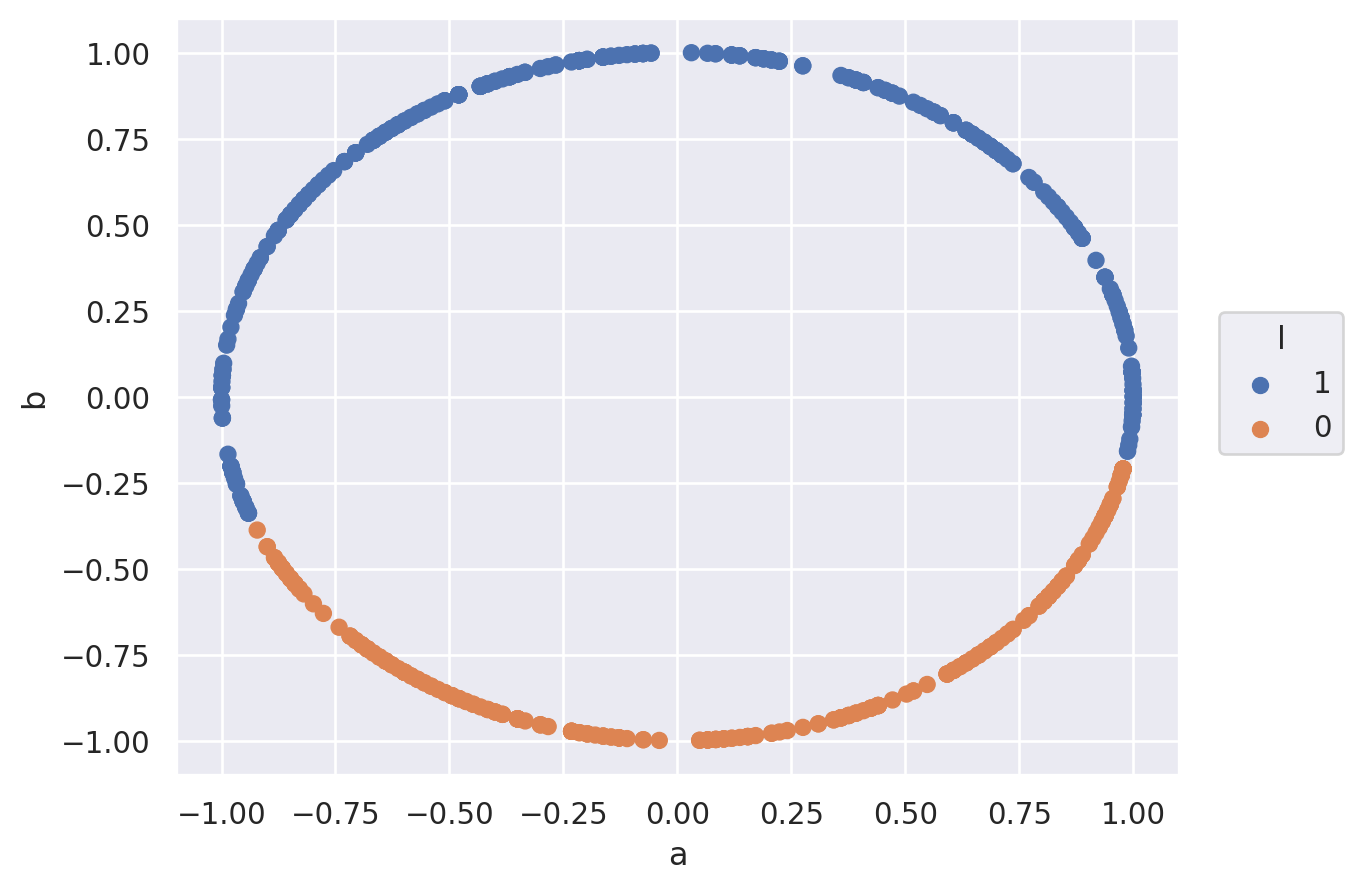

In [47]:
img=cv2.imread('2.jpg')

kernel1 = np.ones((2,4),np.uint8)
kernel2 = np.ones((3,3),np.uint8)

imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#imgBW=cv2.threshold(imgGray, 160, 255, cv2.THRESH_BINARY_INV)[1]
imgBW=cv2.adaptiveThreshold(imgGray, 255,
	cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)

img1=cv2.erode(imgBW, kernel1, iterations=1)
img2=cv2.dilate(img1, kernel2, iterations=1)

""" imgf = ResizeWithAspectRatio(imgBW, width=1280)
cv2.imshow("tophat", imgf)
cv2.waitKey(5000)
cv2.destroyAllWindows() """

img3 = cv2.bitwise_and(imgBW,img2)
img3= cv2.bitwise_not(img3)
img4 = cv2.bitwise_and(imgBW,imgBW,mask=img3)

""" imgf = ResizeWithAspectRatio(img4, width=1280)
cv2.imshow("tophat", imgf)
cv2.waitKey(7000)
cv2.destroyAllWindows() """

for j in [1500]:
    imgLines= cv2.HoughLinesP(img4,j,np.pi/2,2, minLineLength = 250, maxLineGap = 70)

    """ for i in range(len(imgLines)):
        for x1,y1,x2,y2 in imgLines[i]:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2) """
    d = segment_by_angle_kmeans(imgLines)
    segmented = d[0]
    print(d[1])
    #

    #print(segmented[1])
    #print(type(segmented[0][0][0]))
    #print(segmented[0][0][0])
    #print("="*20)
    #print(type(imgLines[0][0]))
    #print(imgLines[0][0])
    for i in range(len(segmented[0])):
        for x1,y1,x2,y2 in segmented[0][i]:
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

    for i in range(len(segmented[1])):
        for x1,y1,x2,y2 in segmented[1][i]:
            cv2.line(img,(x1,y1),(x2,y2),(255,255,0),2)

    imgf = ResizeWithAspectRatio(img, width=1280)
    """ cv2.imshow("tophat", imgf)
    cv2.waitKey(3000)
    cv2.destroyAllWindows() """

print(d[1])
so.Plot(d[1], "a", "b").add(so.Dot(), color="l")


In [3]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [35]:
img=cv2.imread('2.jpg')

filterSize =(10, 10)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                   filterSize)
kernel1 = np.ones((3,5),np.uint8)
kernel2 = np.ones((9,9),np.uint8)

imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
tophat_img = cv2.morphologyEx(imgGray, 
                              cv2.MORPH_BLACKHAT,
                              kernel)
imgBW=cv2.threshold(tophat_img, 230, 255, cv2.THRESH_BINARY_INV)[1]

img1=cv2.erode(imgBW, kernel1, iterations=1)
img2=cv2.dilate(img1, kernel2, iterations=3)
img3 = cv2.bitwise_and(imgBW,img2)
img3= cv2.bitwise_not(img3)
img4 = cv2.bitwise_and(imgBW,imgBW,mask=img3)

cv2.imshow("tophat", img4)
cv2.waitKey(10000)
cv2.destroyAllWindows()

imgLines= cv2.HoughLinesP(img4,15,np.pi/180,10, minLineLength = 440, maxLineGap = 15)

for i in range(len(imgLines)):
    for x1,y1,x2,y2 in imgLines[i]:
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

cv2.imshow('Final Image with dotted Lines detected', img)

TypeError: object of type 'NoneType' has no len()

In [4]:
img=cv2.imread('2.jpg')
img = ResizeWithAspectRatio(img, width=1280)

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    approx = cv2.contourArea(cnt)
    print(approx)

cv2.imshow('image', img)
cv2.imshow('Binary',thresh_img)
cv2.waitKey(10000)
cv2.destroyAllWindows()

738476.0


In [17]:
img_rgb = cv2.imread('2.jpg')

assert img_rgb is not None, "file could not be read, check with os.path.exists()"
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('2_rec_m.png', cv2.IMREAD_GRAYSCALE)
assert template is not None, "file could not be read, check with os.path.exists()"
w, h = template.shape[::-1]
res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.76
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
 cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
#cv2.imwrite('res.png',img_rgb)

img_rgb = ResizeWithAspectRatio(img_rgb, width=1280)
img_gray = ResizeWithAspectRatio(img_gray, width=1280)
res = ResizeWithAspectRatio(res, width=1280)
cv2.imshow('image', res)
cv2.imshow('image1', img_rgb)
cv2.waitKey(10000)
cv2.destroyAllWindows()

In [13]:
loc[::-1]

(array([589, 590, 591, ..., 356, 357, 358]),
 array([ 148,  148,  148, ..., 1284, 1284, 1284]))

In [15]:
img_rgb = cv2.imread('2.jpg')
img=cv2.imread('2.jpg')

kernel1 = np.ones((2,4),np.uint8)
kernel2 = np.ones((3,3),np.uint8)

imgGray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#imgBW=cv2.threshold(imgGray, 160, 255, cv2.THRESH_BINARY_INV)[1]
imgBW=cv2.adaptiveThreshold(imgGray, 255,
	cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)

img1=cv2.erode(imgBW, kernel1, iterations=1)
img2=cv2.dilate(img1, kernel2, iterations=1)
img3 = cv2.bitwise_and(imgBW,img2)
img3= cv2.bitwise_not(img3)
img4 = cv2.bitwise_and(imgBW,imgBW,mask=img3)

assert img_rgb is not None, "file could not be read, check with os.path.exists()"
#img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
img_gray = img4
template = cv2.imread('2_rec_bw.png', cv2.THRESH_BINARY)#, cv2.IMREAD_GRAYSCALE
assert template is not None, "file could not be read, check with os.path.exists()"
w, h = template.shape[::-1]
res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.115
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
 cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
#cv2.imwrite('res.png',img_rgb)

img_rgb = ResizeWithAspectRatio(img_rgb, width=1280)
img_gray = ResizeWithAspectRatio(img_gray, width=1280)
res = ResizeWithAspectRatio(res, width=1280)
cv2.imshow('image', res)
cv2.imshow('image1', img_rgb)
cv2.waitKey(4000)
cv2.destroyAllWindows()

In [38]:
im = Image.open('1f.jpg')
im.save('1f.png')

In [19]:


im = Image.open('2.png')

plt.figure(figsize = (8, 8))
plt.imshow(im)



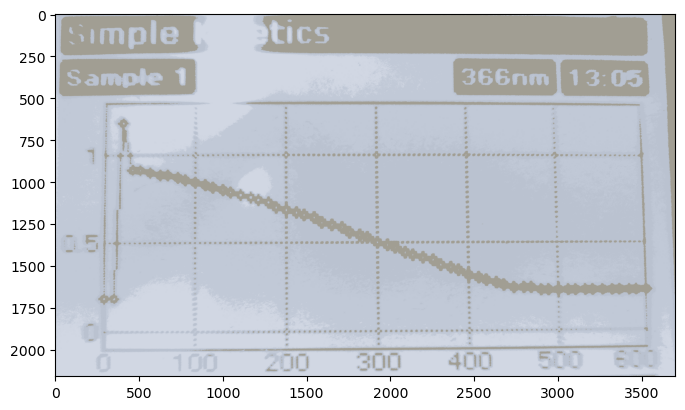

In [40]:


im2 = im.quantize(4)

plt.figure(figsize = (8, 8))
plt.imshow(im2)



In [43]:
ima2 = np.asarray(im2)
print(ima2)

[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


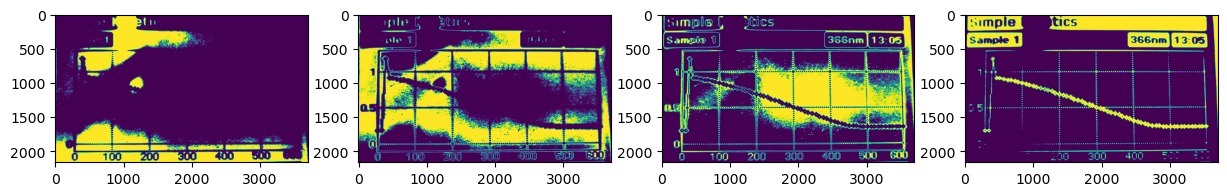

In [44]:


ima2 = np.asarray(im2)
graph0 = ima2 == 0
graph1 = ima2 == 1
graph2 = ima2 == 2
graph3 = ima2 == 3

plt.figure(figsize = (15, 15))
plt.subplot(141); plt.imshow(graph0)
plt.subplot(142); plt.imshow(graph1)
plt.subplot(143); plt.imshow(graph2)
plt.subplot(144); plt.imshow(graph3)

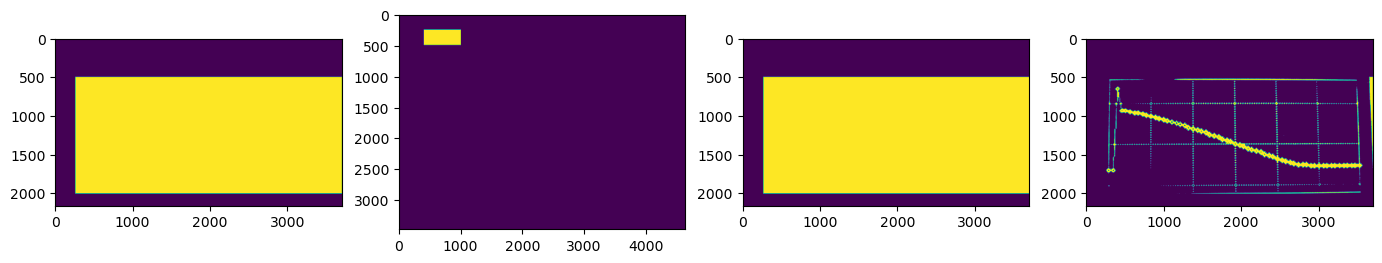

In [47]:


Xg, Yg = ogrid[:graph1.shape[0], :graph1.shape[1]]
mask1 = (Xg >= 500) & (Xg < 2000) & (Yg > 260) & (Yg < 3700)
#mask2 = (Xg >= 250) & (Xg < 500) & (Yg > 400) & (Yg < 1000)
mask = mask1# & ~mask2
masked = graph3 & mask

figure(figsize = (17, 17))
subplot(141); imshow(mask1)
subplot(142); imshow(mask2)
subplot(143); imshow(mask)
subplot(144); imshow(masked);



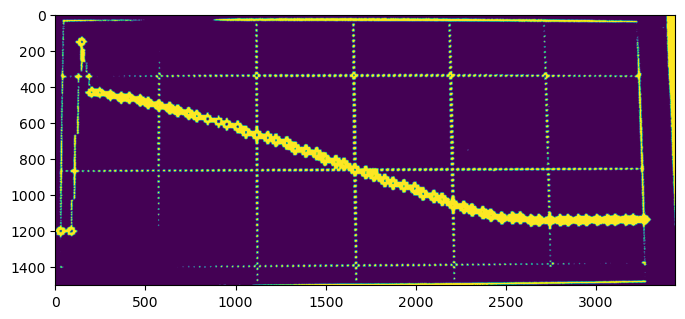

In [48]:
xs, ys = numpy.indices(masked.shape)
xi, yi = xs[masked != 0], ys[masked !=0]
cropped = masked[xi.min():xi.max()+1, yi.min():yi.max()+1]

figure(figsize = (8, 8))
imshow(cropped)

<Axes: >

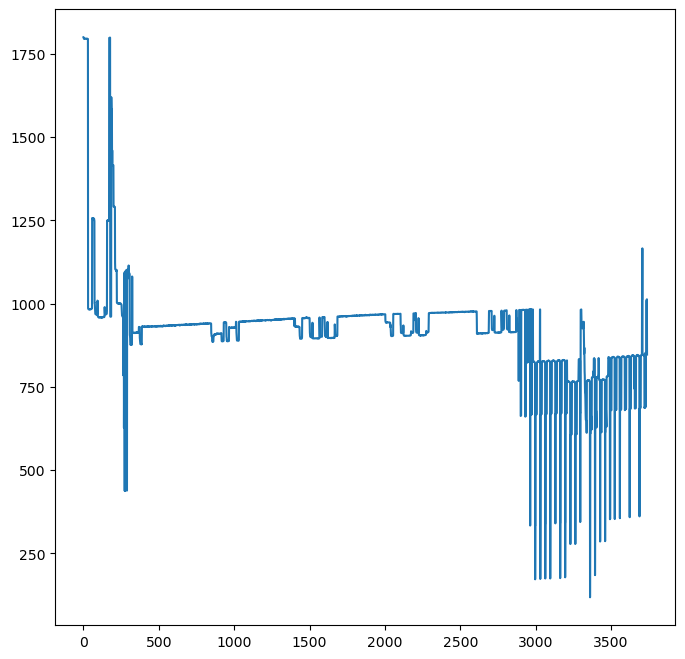

In [17]:


xs, ys = numpy.indices(cropped.shape)
xi, yi = xs[cropped != 0], ys[cropped !=0]

d = {}
for x, y in zip(xi, yi):
    d.setdefault(y, []).append(cropped.shape[0] - x)

y_values = list(d.keys())
x_min = [v[0] for v in d.values()]
x_max = [v[-1] for v in d.values()]
x_mid = [(a + b) / 2 for a, b in zip(x_min, x_max)]

figure(figsize = (8, 8))
#fill_between(y_values, x_min, x_max, alpha=0.2)
sns.lineplot(x=y_values, y=x_mid)



<Axes: >

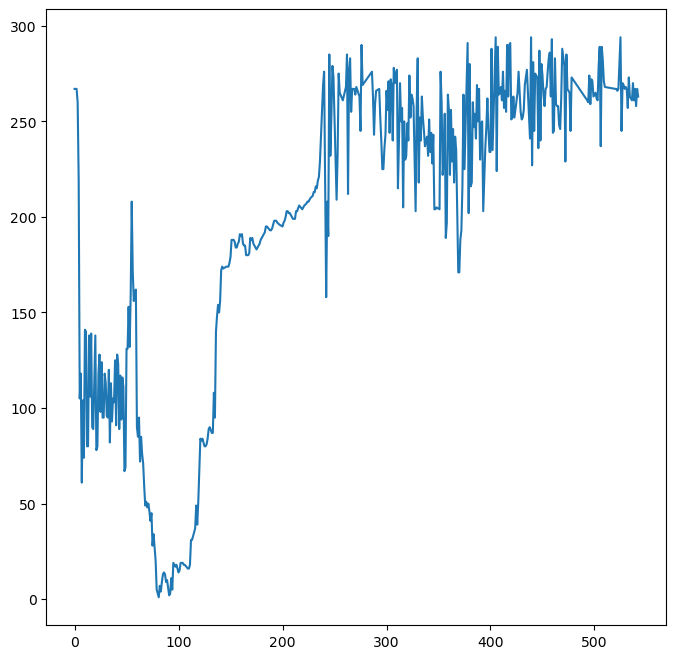

In [17]:
x_dither = [el[i % 2] for i, el in enumerate(zip(x_min, x_max))]
figure(figsize = (8, 8))
#plot(y_values, x_dither)
sns.lineplot(x=y_values, y=x_dither)